In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import ast
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tabulate import tabulate
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [3]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [4]:
# устранение выбросов
Q1 = df['IC50, mM'].quantile(0.25)
Q3 = df['IC50, mM'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['IC50, mM'] >= lower_bound) & (df['IC50, mM'] <= upper_bound)]

In [6]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df = df.drop(df.columns[[2]], axis=1)
df.head()

,"IC50, mM","CC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# добавление фичей
df['Mol_properties_ratio'] = df['HeavyAtomMolWt'] / df['MolWt']
df['Electron_density'] = df['NumValenceElectrons'] / df['HeavyAtomCount']

df['Charge_imbalance'] = df['MaxPartialCharge'] - df['MinPartialCharge']
df['Abs_charge_range'] = df['MaxAbsPartialCharge'] - df['MinAbsPartialCharge']

df['Topological_complexity'] = df['Chi0'] + df['Chi1'] + df['Kappa1'] + df['Kappa2']
peoe_cols = [col for col in df.columns if 'PEOE_VSA' in col]
smr_cols = [col for col in df.columns if 'SMR_VSA' in col]

df['PEOE_VSA_total'] = df[peoe_cols].sum(axis=1)
df['SMR_VSA_total'] = df[smr_cols].sum(axis=1)

fr_cols = [col for col in df.columns if col.startswith('fr_')]
df['Functional_groups_total'] = df[fr_cols].sum(axis=1)

df['H_bond_groups'] = df['NumHAcceptors'] + df['NumHDonors']

df['Ring_complexity'] = (
    df['NumAromaticRings']
    + df['NumAliphaticRings']
    + df['NumSaturatedRings']
)

# удаление исходных фичей
columns_to_drop = peoe_cols + smr_cols + fr_cols + [
    'HeavyAtomMolWt', 'MolWt', 'NumValenceElectrons', 'HeavyAtomCount',
    'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'Chi0', 'Chi1', 'Kappa1', 'Kappa2',
    'NumHAcceptors', 'NumHDonors',
    'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings'
]

df.drop(columns=columns_to_drop, inplace=True)

In [15]:
# бинаризация признаков, если доля нулей выше порога
zero_ratio_threshold = 0.9 

df_binarized = df.copy()

for col in df_binarized.columns:
    zero_ratio = (df_binarized[col] == 0).mean()
    if zero_ratio > zero_ratio_threshold:
        df_binarized[col] = df_binarized[col].apply(lambda x: 1 if x != 0 else 0)

# бинарная целевая переменная: превышает ли значение IC50 медианное значение выборки
median_ic50 = df['IC50, mM'].median()
df['target'] = (df['IC50, mM'] > median_ic50).astype(int)
X = df.drop(['IC50, mM', 'target'], axis=1)
y = df['target']

# удаление константных признаков (если есть)
nunique = X.nunique()
constant_features = nunique[nunique == 1].index.tolist()
X.drop(columns=constant_features, inplace=True)

# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# уменьшение размерности (PCA)
pca = PCA(n_components=0.95)  # сохрание 95% дисперсии
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Обучение моделей

In [17]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_seed=42, verbose=0)
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

results_df = pd.DataFrame(results).T
print(results_df)

[LightGBM] [Info] Number of positive: 342, number of negative: 341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13605
[LightGBM] [Info] Number of data points in the train set: 683, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500732 -> initscore=0.002928
[LightGBM] [Info] Start training from score 0.002928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

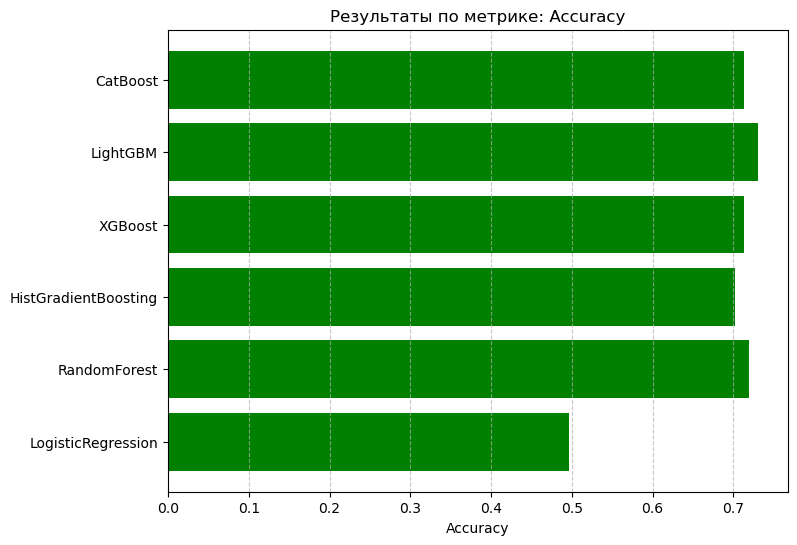

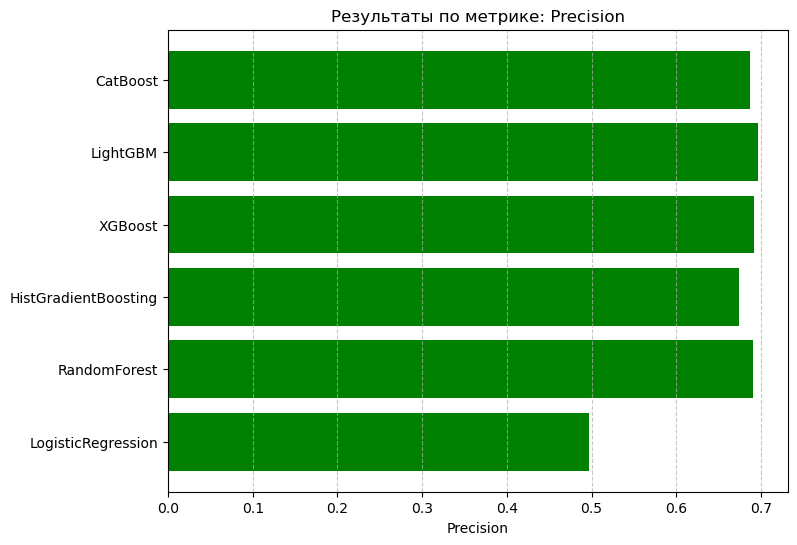

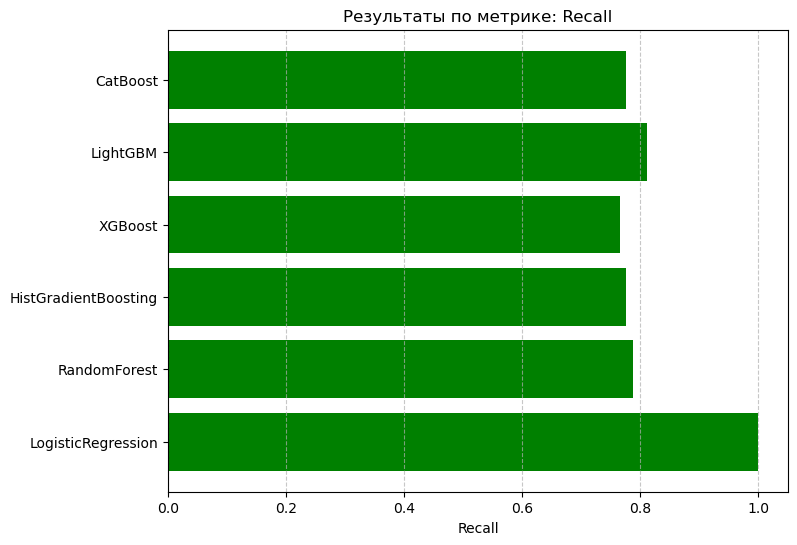

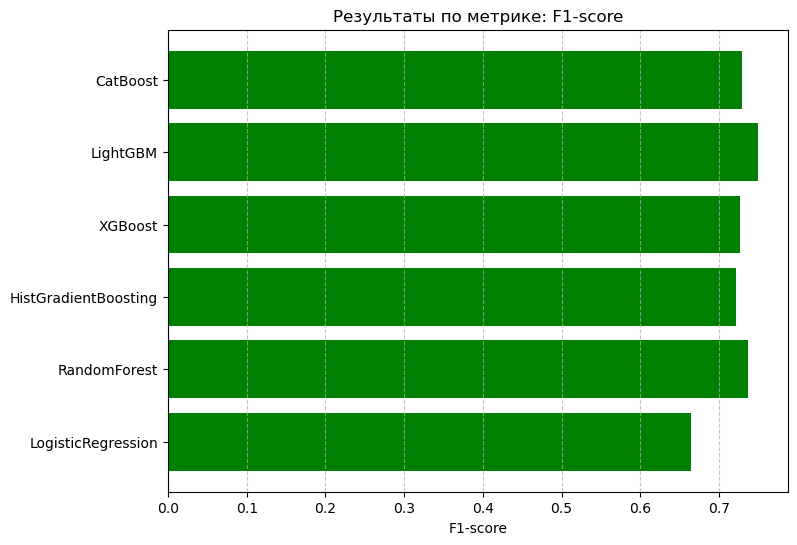

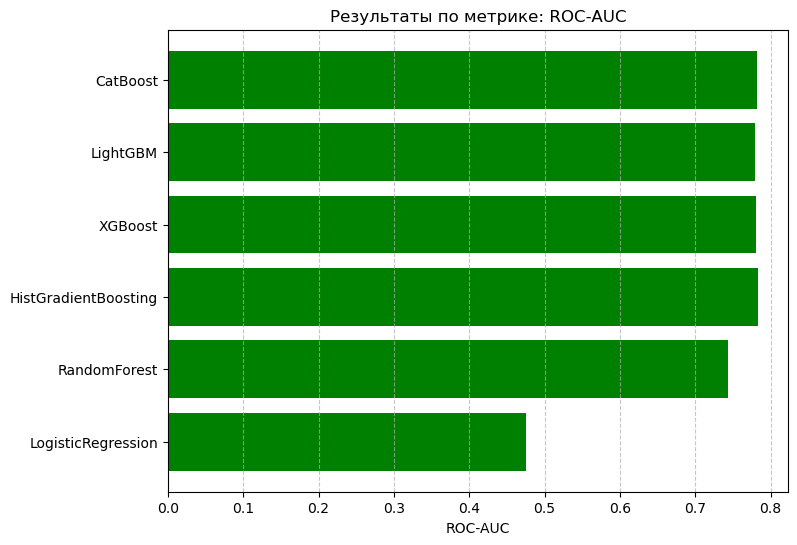

In [18]:
# визуализация результатов
metrics = results_df.columns.tolist()

for metric in metrics:
    plt.figure(figsize=(8,6))
    plt.barh(results_df.index, results_df[metric], color='green')
    plt.xlabel(metric)
    plt.title(f'Результаты по метрике: {metric}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

### Подбор гиперпараметров

In [19]:
models_params = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [100, 200],
            'max_depth': [None, 10],
            'learning_rate': [0.01, 0.1]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [-1, 10],
            'learning_rate': [0.01, 0.1],
            'num_leaves':[31, 50]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_seed=42),
        'params': {
            'iterations':[100, 200],
            'depth':[4,6],
            'learning_rate':[0.01,0.1]
        }
    }
}

results_df = pd.DataFrame(columns=[
    'Модель', 'Лучшие параметры', 
    'Accuracy', 'Precision', 'Recall', 
    'F1-score', 'ROC-AUC'
])

# обучение моделей с подбором гиперпараметров и оценка
for name, mp in models_params.items():
    print(f"\nПодбор гиперпараметров для {name}...")
    grid_search = GridSearchCV(mp['model'], mp['params'], scoring='roc_auc', cv=5)
    grid_search.fit(X_train_pca, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_pred = best_model.predict(X_test_pca)
    y_proba = best_model.predict_proba(X_test_pca)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results_df.loc[len(results_df)] = [
        name,
        str(best_params),
        accuracy,
        precision,
        recall,
        f1score,
        roc_auc
    ]
    
    print(f"Лучшие параметры: {best_params}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1score:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")

results_df_rounded = results_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']:
    results_df_rounded[col] = results_df_rounded[col].round(3)

print("\nИтоговая таблица метрик моделей:")
print(tabulate(results_df_rounded, headers='keys', tablefmt='grid', showindex=False))

# обучение финальной модели на лучших гиперпараметрах 
for name in results_df['Модель']:
    params_str = results_df.loc[results_df['Модель'] == name, 'Лучшие параметры'].values[0]
    best_params_dict = ast.literal_eval(params_str)
    
    if name == "LogisticRegression":
        model_final = LogisticRegression(**best_params_dict, max_iter=1000)
        
    elif name == "Random Forest":
        model_final = RandomForestClassifier(**best_params_dict, random_state=42)
        
    elif name == "XGBoost":
        model_final = xgb.XGBClassifier(**best_params_dict,
                                        use_label_encoder=False,
                                        eval_metric='logloss',
                                        random_state=42)
        
    elif name == "HistGradientBoosting":
        model_final = HistGradientBoostingClassifier(**best_params_dict)
        
    elif name == "LightGBM":
        model_final = lgb.LGBMClassifier(**best_params_dict,
                                         random_state=42)
        
    elif name == "CatBoost":
        model_final = CatBoostClassifier(**best_params_dict)

# Обучаем финальную модель 
model_final.fit(X_train_pca, y_train)


Подбор гиперпараметров для LogisticRegression...
Лучшие параметры: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.637
Precision: 0.616
Recall: 0.718
F1-score: 0.663
ROC-AUC: 0.703

Подбор гиперпараметров для Random Forest...
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.655
Precision: 0.630
Recall: 0.741
F1-score: 0.681
ROC-AUC: 0.729

Подбор гиперпараметров для XGBoost...
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Accuracy: 0.661
Precision: 0.645
Recall: 0.706
F1-score: 0.674
ROC-AUC: 0.696

Подбор гиперпараметров для HistGradientBoosting...
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 100}
Accuracy: 0.690
Precision: 0.674
Recall: 0.729
F1-score: 0.701
ROC-AUC: 0.734

Подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Number of positive: 274, number of negative: 272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 s

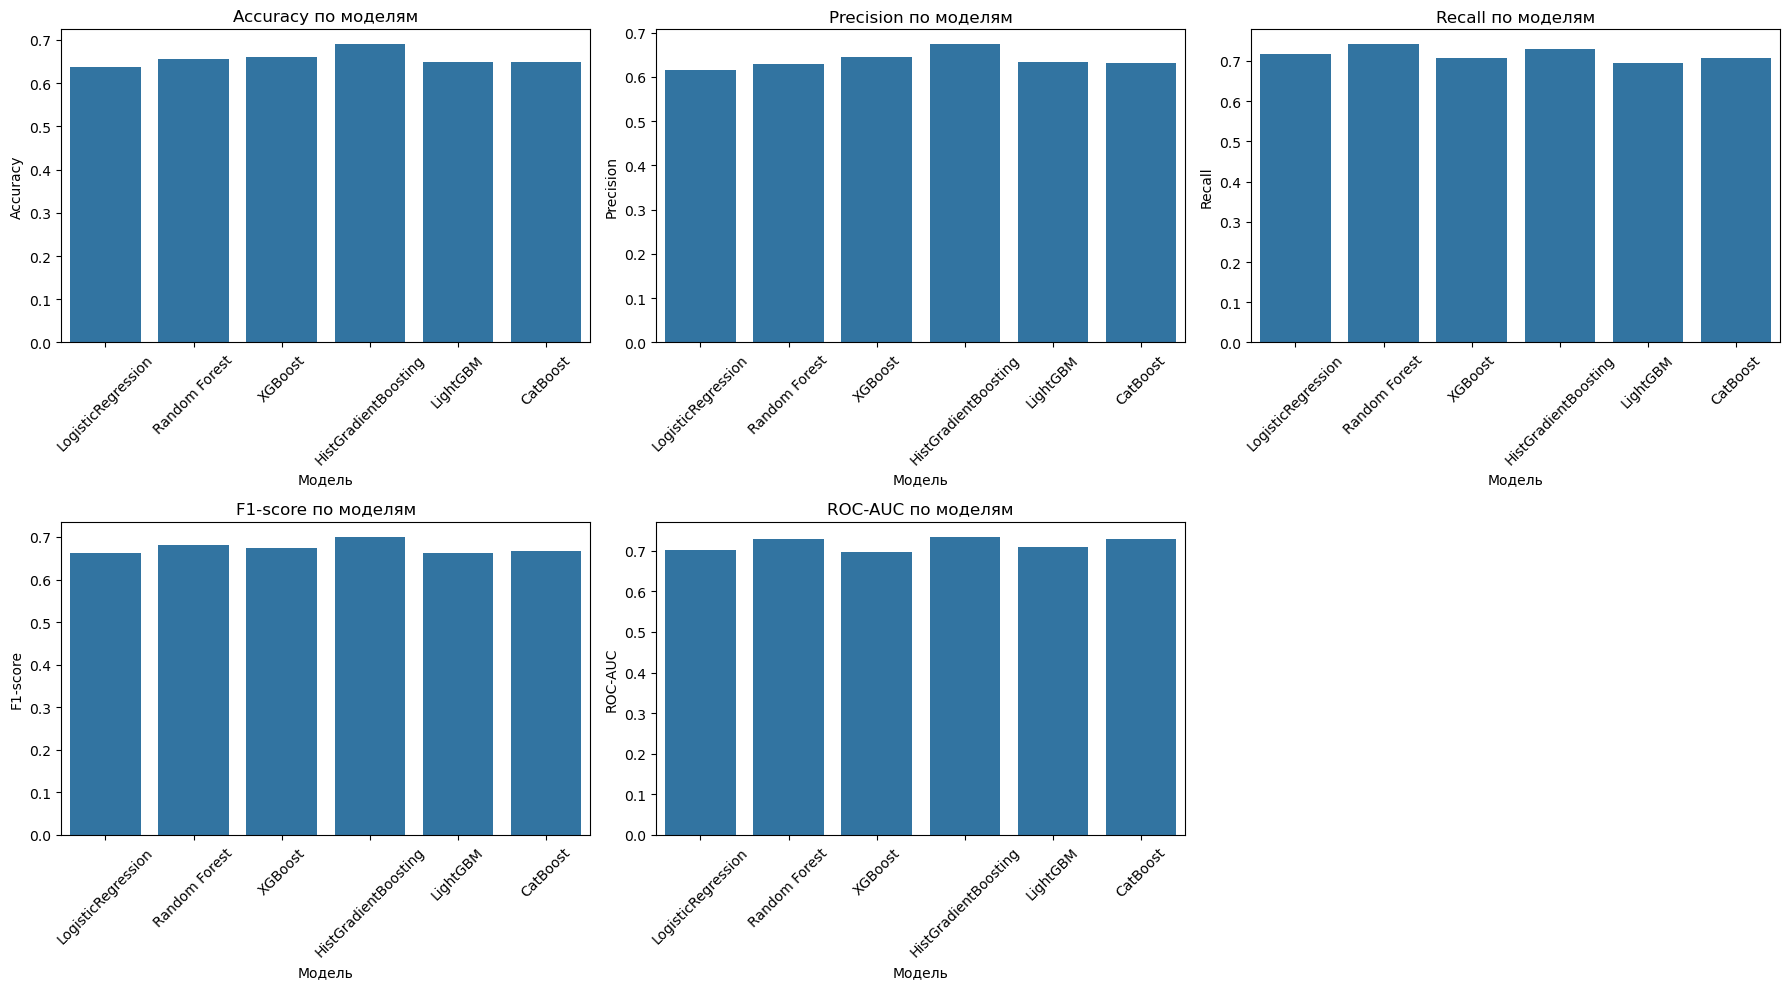

In [20]:
# визуализация
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(
        x='Модель',
        y=metric,
        data=results_df,
        ax=axes[i]
    )
    axes[i].set_title(f'{metric} по моделям')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Модель')
    axes[i].tick_params(axis='x', rotation=45)

if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()